# Damped-Local-Trend(DLT) Example

In [1]:
import pandas as pd
import numpy as np
from orbit.dlt import LGT, DLT
from orbit.utils.utils import plot_predicted_data

## Data

In [2]:
DATA_FILE = "./data/iclaims.example.csv"

In [3]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

In [4]:
raw_df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
raw_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.183973,0.720140,1.119669
1,2010-01-10,825891,1.183973,0.814896,1.178599
2,2010-01-17,659173,1.203382,0.739091,1.119669
3,2010-01-24,507651,1.164564,0.814896,1.107883
4,2010-01-31,538617,1.086926,0.776993,1.072525


### Train / Test Split

In [6]:
df=raw_df.copy()
test_size=52
train_df=df[:-test_size]

# in uTS we make assertion that test dates need to be between train start/end
test_df=df[-test_size:]

## MAP Fit and Predict

In [7]:
dlt_map=DLT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [8]:
dlt_map.fit(df=train_df)

In [9]:
dlt_map.aggregated_posteriors

{'mean': None,
 'median': None,
 'map': {'l': array([[13.91067946, 13.91070906, 13.91100894, 13.91074804, 13.91099283,
          13.91118884, 13.91134547, 13.91159783, 13.91183885, 13.91188896,
          13.91205162, 13.91215779, 13.91219268, 13.9123541 , 13.91248069,
          13.91232857, 13.9120126 , 13.91163988, 13.91120888, 13.91113661,
          13.91083415, 13.91050619, 13.91016475, 13.90994146, 13.9095102 ,
          13.90918995, 13.9090432 , 13.90873033, 13.90825376, 13.90803786,
          13.90812012, 13.90832055, 13.90843308, 13.90826297, 13.90815203,
          13.90788368, 13.90724357, 13.9068077 , 13.90667554, 13.9065397 ,
          13.9065559 , 13.90616141, 13.9057741 , 13.90566316, 13.90550418,
          13.90536113, 13.90491226, 13.90458367, 13.904431  , 13.90428466,
          13.90438908, 13.90396201, 13.90364591, 13.90439884, 13.90293063,
          13.90401403, 13.90322853, 13.90232575, 13.90186239, 13.90028017,
          13.89643657, 13.89579921, 13.89447793, 13.8934

In [10]:
predicted_df = dlt_map.predict(df=test_df)

In [11]:
predicted_df.head(5)

,week,prediction
0,2017-07-02,247388.594684
1,2017-07-09,277362.977789
2,2017-07-16,236834.944622
3,2017-07-23,205441.467557
4,2017-07-30,196087.066698


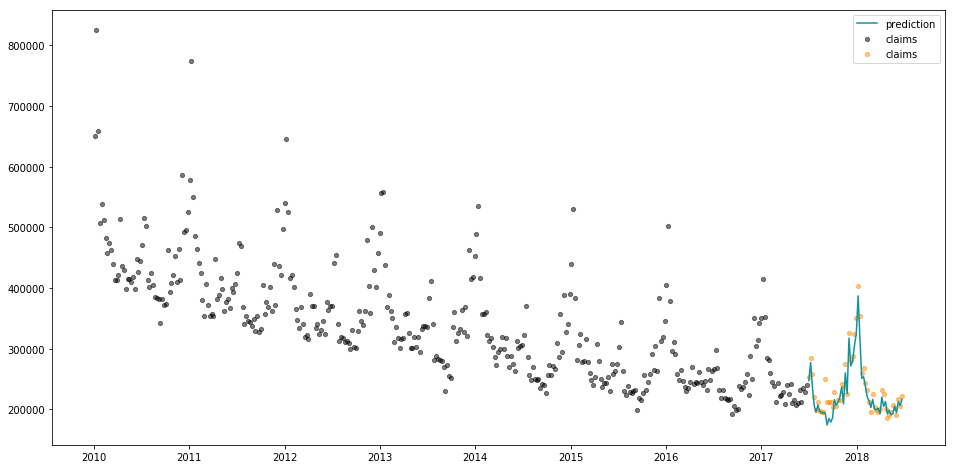

In [12]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_map.date_col, actual_col=dlt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## MCMC Fit and Predict

In [13]:
dlt_mcmc = DLT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    num_warmup=4000, 
    num_sample=500,
    sample_method='mcmc',
    predict_method='full',
    n_bootstrap_draws=500
)

In [14]:
dlt_mcmc.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [15]:
predicted_df = dlt_mcmc.predict(df=test_df)

In [16]:
predicted_df.tail(5)

,week,5,50,95
47,2018-05-27,182959.235157,205277.320679,230707.264288
48,2018-06-03,171366.177245,193755.147616,220681.131852
49,2018-06-10,189316.890799,212151.798585,236906.419611
50,2018-06-17,181551.858196,205944.217998,231289.589058
51,2018-06-24,191795.923139,215442.350652,242497.866588


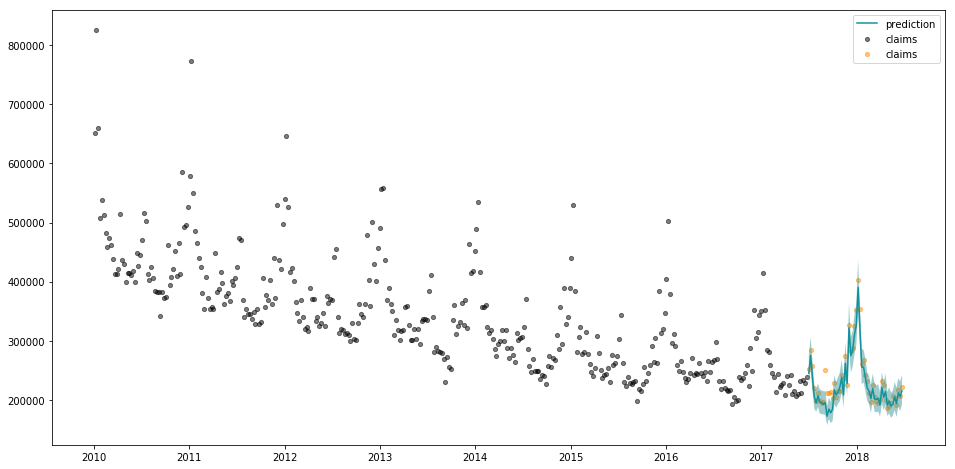

In [17]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_mcmc.date_col, actual_col=dlt_mcmc.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Mean Fit and Predict Decomp

In [18]:
dlt_mean=DLT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='mean'
)

In [19]:
dlt_mean.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [20]:
predicted_df = dlt_mean.predict(df=test_df, decompose=True)

In [21]:
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2017-07-02,245993.880328,232480.643676,1.058126,1.0
1,2017-07-09,276591.932588,232049.238399,1.191954,1.0
2,2017-07-16,237953.290205,231615.511792,1.027363,1.0
3,2017-07-23,205792.490785,231180.103071,0.890183,1.0
4,2017-07-30,195892.016856,230743.522395,0.848960,1.0


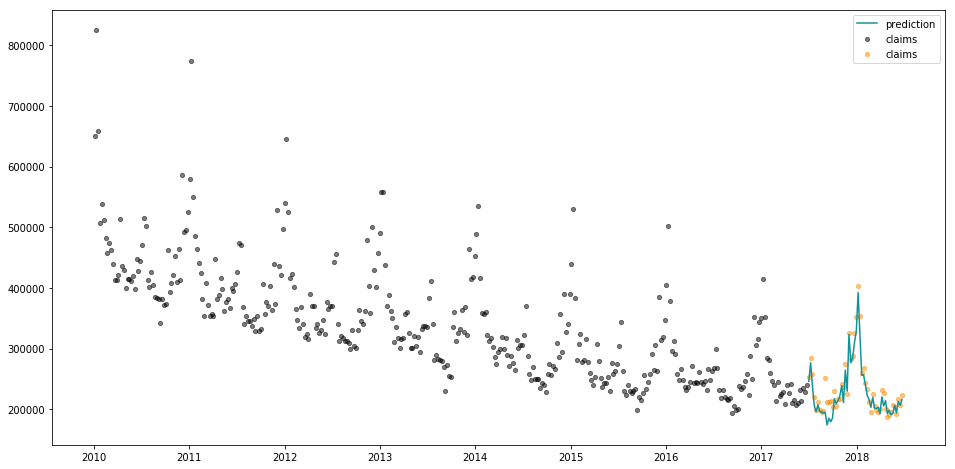

In [22]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=dlt_mean.date_col, actual_col=dlt_mean.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## MAP Fit and Decomp with Regression

In [23]:
dlt_reg=DLT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    date_col='week',
    seasonality=52,
    seed=8888,
    predict_method='map'
)

In [24]:
dlt_reg.fit(df=train_df)

In [25]:
predicted_df = dlt_reg.predict(df=test_df, decompose=True)

In [26]:
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2017-07-02,246644.280397,226830.342370,1.068364,1.017772
1,2017-07-09,275532.390459,226378.199534,1.203673,1.011182
2,2017-07-16,235403.153550,225924.915030,1.029186,1.012405
3,2017-07-23,203143.656489,225470.907095,0.894159,1.007623
4,2017-07-30,195851.960003,225016.509299,0.861432,1.010398
